# Introduction to Robotics (2025)
## Sookmyung W. Univ.
## Lecturer: Prof. Joo Yong Sim
## Tutorial 1: Two-Link Manipulator PD Control — Tutorial


# ✅ **TUTORIAL: 🦾 Two-Link Manipulator PD Control — Full Tutorial **

### *Robotics Lecture • Kinematics • Trajectory Generation • PD Control • Simulation*

Walk through the complete process of controlling a **2-link planar manipulator** with a **joint-space PD controller**.
You will implement forward/inverse kinematics, trajectory generation, system dynamics, and closed-loop control step by step.

## 🔧 Additional Possible Experiments

* Tune PD gains and observe overshoot/settling behavior
* Switch IK to elbow-up mode
* Try circular and sinusoidal paths
* Add gravity terms to dynamics
* Compare joint-space vs workspace control


# 🦾 Two-Link Manipulator PD Control – Tutorial Overview

This tutorial simulates a 2-link planar robot arm tracking a desired end-effector trajectory using a **joint-space PD controller**.

We follow 9 steps that correspond exactly to the code structure.

A conceptual diagram of a 2-link planar robot:

![2-link planar manipulator](https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Planar_2R_Robot_Kinematics.svg/640px-Planar_2R_Robot_Kinematics.svg.png)


---

# **1. Robot and Simulation Parameters**

We define the physical model of the robot and simulation time settings.

* Link lengths:
  $l_1 = 0.5,$m,
  $l_2 = 0.5,$m

* Joint inertias:
  $J_{\text{real}} = [0.8,\ 0.5]$

* Joint viscous friction:
  $b_{\text{real}} = [0.15,\ 0.1]$

* Simulation:

  * Time step: $dt = 0.001,$s
  * Total time: $T_{\text{total}} = 2,$s
  * Steps: $N = T_{\text{total}} / dt$

These parameters define the robot’s geometry and its dynamic behavior.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ======================================
# 1. Robot / Simulation Parameters
# ======================================
# Link lengths (m)
l1 = 0.5
l2 = 0.5

# True system parameters (for each joint)
J_real = np.array([0.8, 0.5])   # Inertia
b_real = np.array([0.15, 0.1])  # Viscous friction

# Simulation settings
dt = 0.001
T_total = 2.0
N = int(T_total / dt)


---

# **2. Forward Kinematics (FK)**

Forward kinematics converts joint angles into the end-effector $(x, y)$:

$$
x = l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2)
$$

$$
y = l_1 \sin(\theta_1) + l_2 \sin(\theta_1 + \theta_2)
$$

FK allows us to:

* Visualize the end-effector path
* Evaluate workspace tracking accuracy
* Verify whether joint motion produces the correct spatial movement


In [2]:

# ======================================
# 2. Forward Kinematics (for verification / plotting)
# ======================================
def fk_2link(theta1, theta2):
    """
    Forward kinematics of a 2-link planar manipulator.
    Inputs:
        theta1, theta2 [rad] : joint angles
    Outputs:
        (x, y) : end-effector position in the plane
    """
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return x, y


---

# **3. Inverse Kinematics (IK)**

IK solves the opposite problem:

> Given $(x, y)$, find the joint angles $(\theta_1, \theta_2)$.

1. Law of cosines:

$$
c_2 = \cos(\theta_2)
= \frac{x^2 + y^2 - l_1^2 - l_2^2}{2 l_1 l_2}
$$

2. Then:

$$
s_2 = \pm \sqrt{1 - c_2^2}
$$

* $-$ → elbow-down
* $+$ → elbow-up

Thus,

$$
\theta_2 = \text{atan2}(s_2,\ c_2)
$$

3. For $\theta_1$:

$$
k_1 = l_1 + l_2 c_2,\quad
k_2 = l_2 s_2
$$

$$
\theta_1 = \text{atan2}(y, x) - \text{atan2}(k_2, k_1)
$$

IK is essential because our desired trajectory is defined in **workspace**, but our PD controller operates in **joint space**.


In [3]:


# ======================================
# 3. Inverse Kinematics
# ======================================
def ik_2link(x, y, elbow='down'):
    """
    Analytic inverse kinematics for a 2-link planar manipulator.
    Assumes (x, y) is within the reachable workspace.

    Args:
        x, y         : desired end-effector position
        elbow (str)  : 'down' or 'up' configuration of the arm

    Returns:
        theta1, theta2 [rad]
    """
    # Compute cos(theta2) using the law of cosines
    c2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)

    # Clip due to possible numerical small overshoot (|c2| > 1)
    c2 = np.clip(c2, -1.0, 1.0)

    # Choose the sign of sin(theta2) depending on elbow configuration
    if elbow == 'down':
        s2 = -np.sqrt(1 - c2**2)
    else:
        s2 = np.sqrt(1 - c2**2)

    theta2 = np.arctan2(s2, c2)

    # Compute theta1 using geometric construction
    k1 = l1 + l2 * c2
    k2 = l2 * s2
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)

    return theta1, theta2


---

# **4. Desired End-effector Trajectory**

We move the end-effector from:

* Start: $(x_{\text{start}}, y_{\text{start}})$
* Goal: $(x_{\text{goal}}, y_{\text{goal}})$

over a time interval:

$$
T_{\text{move}} = 1.5 \text{ s}
$$

We use normalized time:

$$
s = \frac{t}{T_{\text{move}}}
$$

To create a smooth trajectory with zero velocity at start and end, we use a **3-2-1 polynomial**:

$$
s_{\text{smooth}} = 3s^2 - 2s^3
$$

Then interpolate:

$$
x_d(t) = x_{\text{start}} + (x_{\text{goal}} - x_{\text{start}}), s_{\text{smooth}}
$$

$$
y_d(t) = y_{\text{start}} + (y_{\text{goal}} - y_{\text{start}}), s_{\text{smooth}}
$$

For $t > T_{\text{move}}$, the desired point remains fixed at the goal.


In [4]:
# ======================================
# 4. Desired End-effector Trajectory
# ======================================
# Start and goal points (within 1 m arm reach)
x_start, y_start = 0.6, 0.2
x_goal,  y_goal  = 0.2, 0.6

T_move = 1.5  # Move from start to goal over this time (seconds)

def desired_xy_trajectory(t):
    """
    Desired end-effector trajectory in workspace (x, y).

    For 0 <= t <= T_move:
        Move from (x_start, y_start) to (x_goal, y_goal) along a straight line.
        The interpolation uses a 3-2-1 polynomial s(t) for smooth start/stop:
            s_smooth = 3*s^2 - 2*s^3, where s = t / T_move.

    For t > T_move:
        Stay at the goal position (x_goal, y_goal).
    """
    if t >= T_move:
        return x_goal, y_goal

    s = t / T_move
    # 3-2-1 polynomial (smooth start and stop)
    s_smooth = 3 * s**2 - 2 * s**3

    x_d = x_start + (x_goal - x_start) * s_smooth
    y_d = y_start + (y_goal - y_start) * s_smooth
    return x_d, y_d



# **5. Desired Joint Trajectory and Velocities**

For each time index $k$:

1. Compute desired workspace position:
   $(x_d(t_k), y_d(t_k))$
2. Apply IK to get:
   $(\theta_{1d}(t_k), \theta_{2d}(t_k))$

We then approximate desired joint velocities numerically:

$$
\dot{\theta}*d(t_k)
\approx \frac{\theta_d(t*{k+1}) - \theta_d(t_{k-1})}{2,dt}
$$

The PD controller uses both:

$$
e = \theta_d - \theta,\qquad
\dot{e} = \dot{\theta}_d - \dot{\theta}
$$

So having smooth $\dot{\theta}_d$ improves control performance.

---

In [5]:
# ======================================
# 5. Pre-compute Desired Joint Trajectory (theta_d) and Its Derivative
# ======================================
theta_d = np.zeros((N, 2))  # [theta1_d, theta2_d] for each time step
time = np.arange(N) * dt

# Inverse kinematics for each point along the desired (x, y) trajectory
for k in range(N):
    t = time[k]
    x_d, y_d = desired_xy_trajectory(t)
    th1_d, th2_d = ik_2link(x_d, y_d, elbow='down')
    theta_d[k, 0] = th1_d
    theta_d[k, 1] = th2_d

# Desired joint velocities: numerical differentiation w.r.t. time
theta_d_dot = np.gradient(theta_d, dt, axis=0)



---

# **6. Plant Dynamics (Joint-Level Model)**

Each joint is modeled as:

$$
J \ddot{\theta} + b \dot{\theta} = \tau
$$

Solving for $\ddot{\theta}$:

$$
\ddot{\theta} = \frac{\tau - b\dot{\theta}}{J}
$$

We update the state using **semi-implicit Euler**:

Velocity update:

$$
\dot{\theta}_{k+1}
= \dot{\theta}_k + \ddot{\theta}_k, dt
$$

Position update (using the new velocity):

$$
\theta_{k+1}
= \theta_k + \dot{\theta}_{k+1}, dt
$$

This method is more stable than explicit Euler for mechanical systems.

In [6]:
# ======================================
# 6. Actual System (Plant) Dynamics
# ======================================
def plant_step(theta, theta_dot, tau):
    """
    Discrete-time update of the joint states using a simple
    second-order model for each joint:

        J_real * ddtheta + b_real * dtheta = tau

    We integrate with semi-implicit (symplectic) Euler:
        theta_dot_{k+1} = theta_dot_k + ddtheta * dt
        theta_{k+1}     = theta_k     + theta_dot_{k+1} * dt

    Args:
        theta      : current joint angles [rad], shape (2,)
        theta_dot  : current joint velocities [rad/s], shape (2,)
        tau        : applied joint torques [Nm], shape (2,)

    Returns:
        theta_new, theta_dot_new
    """
    ddtheta = (tau - b_real * theta_dot) / J_real
    theta_dot_new = theta_dot + ddtheta * dt
    theta_new = theta + theta_dot_new * dt
    return theta_new, theta_dot_new


# **7. Joint-Space PD Controller**

For each joint:

* Position error:

$$
e = \theta_d - \theta
$$

* Velocity error:

$$
\dot{e} = \dot{\theta}_d - \dot{\theta}
$$

The control law is:

$$
\tau = K_p \odot e + K_d \odot \dot{e}
$$

Where:

* $K_p = [K_{p1}, K_{p2}]$
* $K_d = [K_{d1}, K_{d2}]$
* $\odot$ = element-wise multiplication

**Effects of gains:**

* Higher $K_p$ → faster response, larger overshoot
* Higher $K_d$ → more damping, less oscillation

Example step-response behavior (for intuition):

![PD response example](https://pressbooks.library.torontomu.ca/app/uploads/sites/192/2021/03/Figure-9-12-Closed-Loop-Step-response-of-the-example-System-under-Proportional-Plus-Derivative-Control-1024x768.png)


In [7]:

# ======================================
# 7. Joint-space PD Controller
# ======================================
# Gains (students are expected to experiment with these)
Kp = np.array([80.0, 60.0])
Kd = np.array([8.0, 6.0])

def joint_pd_controller(k, theta, theta_dot):
    """
    Joint-space PD controller.

    At time index k:
        e  = theta_d[k]     - theta
        de = theta_d_dot[k] - theta_dot
        tau_i = Kp_i * e_i + Kd_i * de_i

    Args:
        k         : time index (int)
        theta     : current joint angles, shape (2,)
        theta_dot : current joint velocities, shape (2,)

    Returns:
        tau : control torques, shape (2,)
        e   : joint angle error
        de  : joint velocity error
    """
    theta_d_k = theta_d[k]
    theta_d_dot_k = theta_d_dot[k]

    # Compute errors and PD torque
    e = theta_d_k - theta
    de = theta_d_dot_k - theta_dot
    tau = Kp * e + Kd * de

    return tau, e, de



---

# **8. Closed-Loop Simulation Loop**

The function `simulate_closed_loop()` performs:

### **Initialization**

$$
\theta(0) = [0, 0],\quad
\dot{\theta}(0) = [0, 0]
$$

Allocate logs:

* `theta_log`
* `theta_d_log`
* `e_log`
* `xy_log`
* `xy_d_log`

### **Main loop (for each timestep $k$)**

1. Controller computes torque:

$$
\tau(k),\ e(k),\ \dot{e}(k)
= \text{PD}(\theta(k), \dot{\theta}(k), \theta_d(k), \dot{\theta}_d(k))
$$

2. Plant updates state:

$$
\theta(k+1),\ \dot{\theta}(k+1)
= \text{plant_step}(\theta(k), \dot{\theta}(k), \tau(k))
$$

3. Log joint and workspace positions.

This loop forms the complete **closed-loop control system**.

---

In [8]:
# ======================================
# 8. Closed-loop Simulation
# ======================================
def simulate_closed_loop():
    """
    Simulate the closed-loop behavior of the 2-link arm
    under the joint-space PD controller.

    Steps:
        - Initialize joint states at rest (theta = 0, theta_dot = 0)
        - For each time step:
            * Compute control torque using PD controller
            * Propagate the plant dynamics
            * Log joint states, desired states, error, and (x, y) positions
    """
    # Initial joint states: arm is fully folded along the x-axis
    theta = np.array([0.0, 0.0])
    theta_dot = np.array([0.0, 0.0])

    theta_log = np.zeros((N, 2))
    theta_d_log = np.zeros((N, 2))
    e_log = np.zeros((N, 2))
    xy_log = np.zeros((N, 2))
    xy_d_log = np.zeros((N, 2))

    for k in range(N):
        # Controller: compute torque and errors
        tau, e, de = joint_pd_controller(k, theta, theta_dot)

        # Plant dynamics: update joint states
        theta, theta_dot = plant_step(theta, theta_dot, tau)

        # Logging joint states and errors
        theta_log[k] = theta
        theta_d_log[k] = theta_d[k]
        e_log[k] = e

        # End-effector actual and desired positions (for plotting in workspace)
        x, y = fk_2link(theta[0], theta[1])
        xd, yd = fk_2link(theta_d[k, 0], theta_d[k, 1])
        xy_log[k] = [x, y]
        xy_d_log[k] = [xd, yd]

    return theta_log, theta_d_log, e_log, xy_log, xy_d_log



# **9. Plotting and Analysis**

After running the simulation, we generate three sets of plots.

---

## **9.1 End-effector Trajectory (Workspace)**

Plots:

* Desired $(x_d, y_d)$ — dashed line
* Actual $(x, y)$ — solid line

Interpretation:

* The more closely the curves overlap, the better the workspace tracking.

---

## **9.2 Joint Angle Tracking**

For each joint:

* Desired $\theta_d(t)$
* Actual $\theta(t)$

This reveals:

* Overshoot
* Response speed
* Oscillation
* Steady-state accuracy

---

## **9.3 Joint Tracking Error**

We plot:

$$
e_1(t) = \theta_{1d}(t) - \theta_1(t)
$$

$$
e_2(t) = \theta_{2d}(t) - \theta_2(t)
$$

A well-tuned PD controller produces:

* Rapid decay of error
* Minimal oscillation
* Small steady-state error


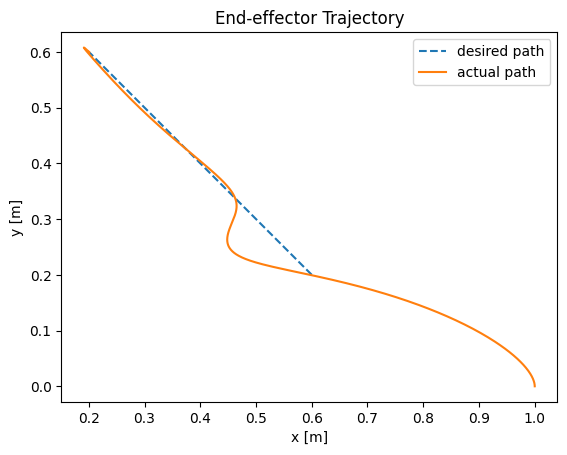

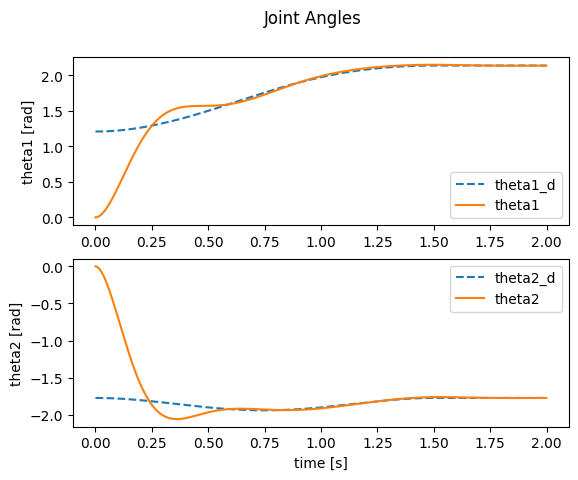

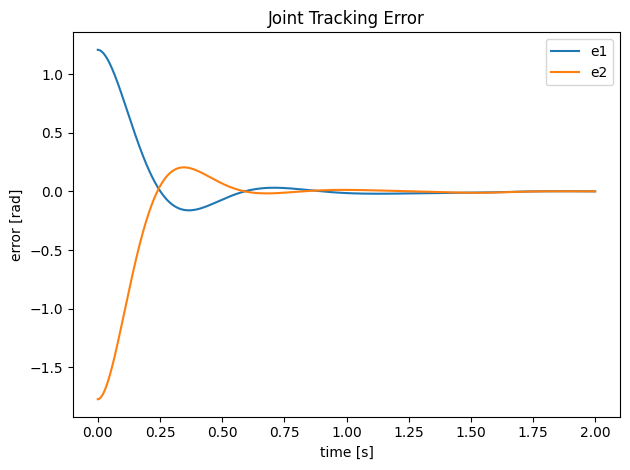

In [9]:
# ======================================
# 9. Run Simulation and Plot Results
# ======================================

theta_log, theta_d_log, e_log, xy_log, xy_d_log = simulate_closed_loop()

# (1) End-effector trajectory comparison in workspace
plt.figure()
plt.plot(xy_d_log[:, 0], xy_d_log[:, 1], '--', label='desired path')
plt.plot(xy_log[:, 0],   xy_log[:, 1],   label='actual path')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.legend()
plt.title('End-effector Trajectory')

# (2) Joint angle time responses
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, theta_d_log[:, 0], '--', label='theta1_d')
plt.plot(time, theta_log[:, 0], label='theta1')
plt.ylabel('theta1 [rad]')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, theta_d_log[:, 1], '--', label='theta2_d')
plt.plot(time, theta_log[:, 1], label='theta2')
plt.xlabel('time [s]')
plt.ylabel('theta2 [rad]')
plt.legend()
plt.suptitle('Joint Angles')

# (3) Tracking error plot
plt.figure()
plt.plot(time, e_log[:, 0], label='e1')
plt.plot(time, e_log[:, 1], label='e2')
plt.xlabel('time [s]')
plt.ylabel('error [rad]')
plt.legend()
plt.title('Joint Tracking Error')

plt.tight_layout()
plt.show()
